# Theft Crime Prediction using KDE Tweets in Cicago

In [1]:
%matplotlib inline

import os
import glob
import itertools
import functools
import collections

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from tqdm import tqdm_notebook, tqdm

from utils.consts import START_DATE, END_DATE, \
                         RAW_CRIMES_DATA_PATH, PROCESSED_CRIMES_DATA_PATH, \
                         RAW_TWEETS_DATA_WILDCARD_PATH, PROCESSED_TWEETS_DATA_PATH, \
                         CSV_DATE_FORMART

from utils.lda import print_top_words_LDA, print_top_words_LDA, get_topic_top_words_LDA

from utils.surveillance import generate_all_data_surveillance_data, \
                               generate_one_step_datasets, generate_surveillance_data, calc_AUCs
    
from utils.visualization import plot_contour, plot_scatter, plot_imshow, plot_log_reg_coef, plot_surveillance_data


/anaconda3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
import warnings
warnings.simplefilter('ignore')

## Pipline Diagram

![title](./ANLP-Project-Pipeline.png)

## Research Time Frame

In [3]:
print(START_DATE, '--->', END_DATE)

2019-06-23 ---> 2019-07-26


## Data Sources & Preprocessing

### Chicago Crimes Incidents (only THEFT)

In [4]:
if not os.path.exists(PROCESSED_CRIMES_DATA_PATH):
    !python3 ./preprocess_crimes_data.py {RAW_CRIMES_DATA_PATH}  {PROCESSED_CRIMES_DATA_PATH}

In [5]:
crimes_data = pd.read_csv(PROCESSED_CRIMES_DATA_PATH)
crimes_data['timestamp'] = pd.to_datetime(crimes_data['timestamp'], format=CSV_DATE_FORMART).dt.normalize()

In [6]:
len(crimes_data)

736

In [7]:
crimes_data['timestamp'].agg(['min', 'max'])

min   2019-06-23
max   2019-07-18
Name: timestamp, dtype: datetime64[ns]

### Tweets

In [8]:
if not os.path.exists(PROCESSED_TWEETS_DATA_PATH):
    !python3 -W ignore ./preprocess_tweets_data.py {RAW_TWEETS_DATA_WILDCARD_PATH} {PROCESSED_TWEETS_DATA_PATH}

In [9]:
tweets_data = pd.read_csv(PROCESSED_TWEETS_DATA_PATH)
tweets_data['timestamp'] = pd.to_datetime(tweets_data['timestamp'], format=CSV_DATE_FORMART).dt.normalize()
tweets_data['tokens'] = tweets_data['tokens'].apply(lambda x: eval(x))

In [10]:
len(tweets_data)

55100

In [11]:
tweets_data.head(3)

Unnamed: 0                   id  timestamp   latitude  longitude  \
0          19  1151318285385789445 2019-07-17  41.845718 -87.889338   
1          22  1151318292482707459 2019-07-17  41.883222 -87.632496   
2          25  1151318313689071617 2019-07-17  41.903050 -87.668940   

                                                text  latitude_index  \
0  Interested in a job in #Westchester, IL? This ...               4   
1  Last 36 hours of our trip. Tomorrow we go home...              25   
2  I'm at Wicker Park Athletic Club in Chicago, I...              22   

   longitude_index                                             tokens  
0               22  [Interested, in, a, job, in, #Westchester, ,, ...  
1               26  [Last, 36, hours, of, our, trip, ., Tomorrow, ...  
2               28  [I'm, at, Wicker, Park, Athletic, Club, in, Ch...

In [12]:
tweets_data.columns

Index(['Unnamed: 0', 'id', 'timestamp', 'latitude', 'longitude', 'text',
       'latitude_index', 'longitude_index', 'tokens'],
      dtype='object')

In [13]:
tweets_data['timestamp'].agg(['min', 'max'])

min   2019-06-23
max   2019-07-26
Name: timestamp, dtype: datetime64[ns]

### Enreaching every Tweet with Sentiment Analysis

For **demonstration propuse**, the training and evaluation of the Sentiment Analysis Model is done every time the notebook is executed.
The same goes for calculating the sentiment value for each tweet.

In [14]:
%%time

from utils.sentiment.sentiment import calculate_sentiment_tweet

Length of the testing Corpus : 10662
Adding unigrams and bigrams sentiment scores 

average fit_time : 0.24237608909606934
average score_time : 0.006046962738037109
average test_f1_micro : 0.7554900886087512
average test_f1_macro : 0.7554053496579932
average test_precision_micro : 0.7554900886087512
average test_precision_macro : 0.7558688268181593
average test_recall_micro : 0.7554900886087512
average test_recall_macro : 0.7554900886087512
                                    Topics    Results
0               Number of tweets in Corpus      10662
1  Average micro test precision percentage  75.5490 %
2  Average macro test precision percentage  75.5868 %
3     Average micro test recall percentage  75.5490 %
4     Average macro test recall percentage  75.5490 %
CPU times: user 5.38 s, sys: 126 ms, total: 5.51 s
Wall time: 5.52 s


In [15]:
%%time

tweets_data['sentiment'] = tweets_data['tokens'].apply(lambda x: calculate_sentiment_tweet(' '.join(x)))

CPU times: user 53.2 s, sys: 313 ms, total: 53.6 s
Wall time: 53.6 s


## Detailed analysis of 31 days training dataset and the successive single day for evaluation

### Generating the train dataset with all the features (KDA, SENTIMENT, LDA) and the evaluation dataset (successive day crime incidents)

In [16]:
%%time

train_dataset, evaluation_dataset = generate_one_step_datasets(crimes_data,
                                                               tweets_data,
                                                               START_DATE,
                                                               15)

CPU times: user 5min 39s, sys: 8.06 s, total: 5min 47s
Wall time: 1min 47s


In [17]:
#train_dataset['X']

In [18]:
#train_dataset['Y']

In [22]:
train_dataset['X']['SENTIMENT']

0       -0.139160
1       -0.175947
2       -0.626971
3       -0.195208
4        0.000000
5       -0.398533
6       -0.162824
7       -0.195208
8       -0.195208
9       -0.182075
10      -0.168928
11      -0.108148
12      -0.199512
13      -0.220206
14       0.000000
15      -0.007143
16      -0.108491
17      -0.328577
18       0.000000
19      -0.509023
20      -0.289906
21       0.000000
22       0.919559
23       0.832361
24       0.000000
25      -0.094585
26      -0.155783
27      -0.180349
28      -0.332415
29      -0.167043
           ...   
36545    0.000000
36546    0.000000
36547    0.000000
36548    0.000000
36549    0.000000
36550    0.000000
36551    0.000000
36552    0.000000
36553    0.000000
36554    0.000000
36555    0.000000
36556    0.000000
36557    0.000000
36558    0.000000
36559    0.000000
36560    0.000000
36561    0.000000
36562    0.000000
36563    0.000000
36564    0.000000
36565    0.000000
36566    0.000000
36567    0.000000
36568    0.000000
36569    0

#### KDE

Text(0.5, 1.0, 'Crime Incidents: 2019-06-23+31 days')

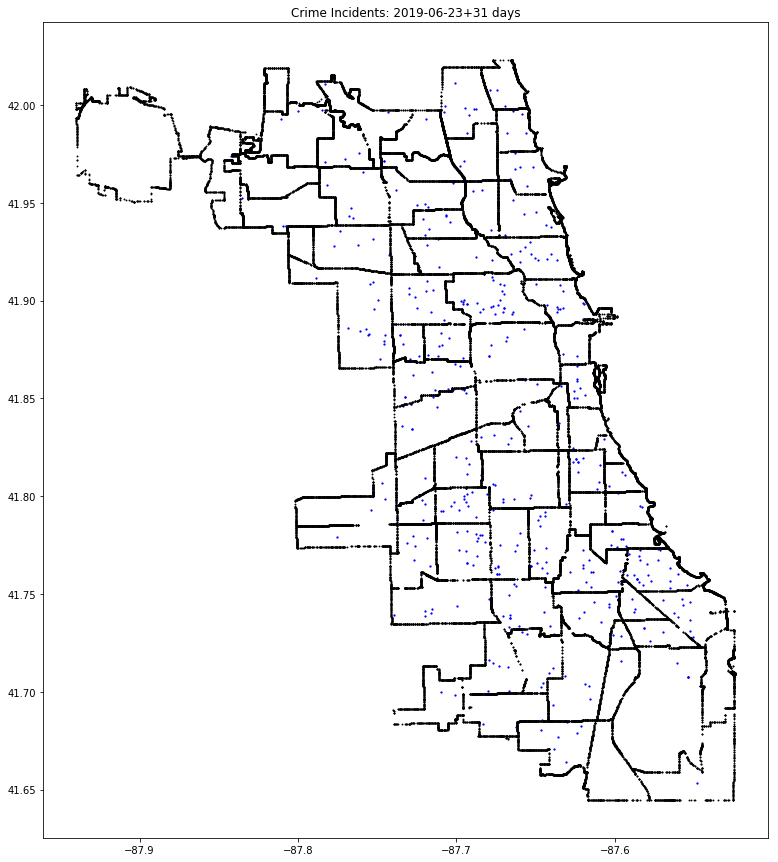

In [31]:
plot_scatter(train_dataset['X'][train_dataset['Y']][['latitude', 'longitude']])
plt.title('Crime Incidents: {}+31 days'.format(START_DATE))

Text(0.5, 1.0, 'KDE of Crime Incidents: 2019-06-23+31 days')

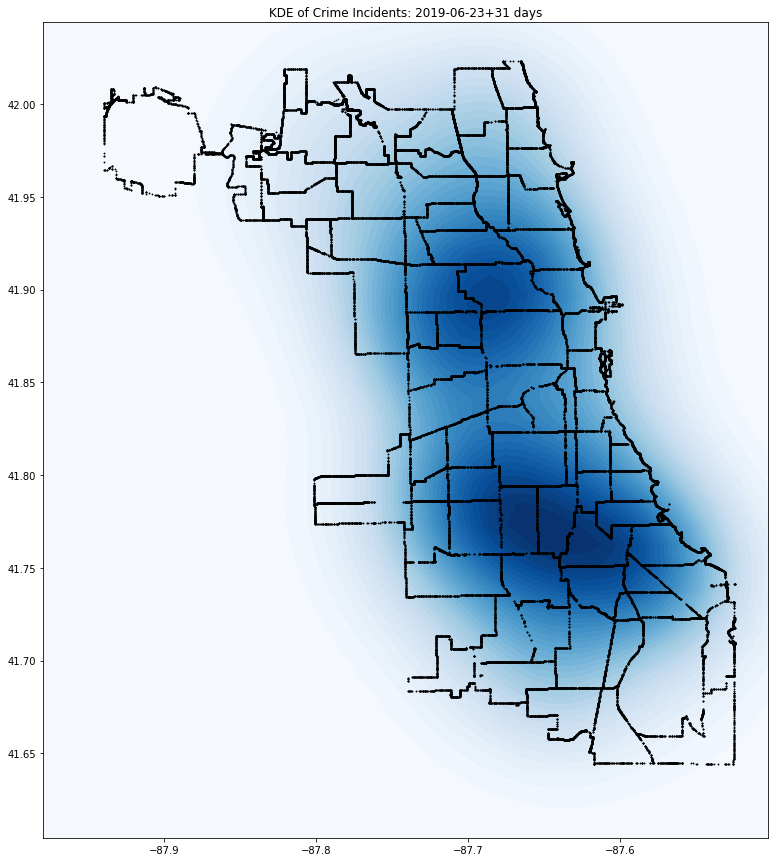

In [32]:
plot_contour(train_dataset['KDE'])
plt.title('KDE of Crime Incidents: {}+31 days'.format(START_DATE))

#### Sentiment

Text(0.5, 1.0, 'Sentiment Histogram & Distribution over Geo Documents')

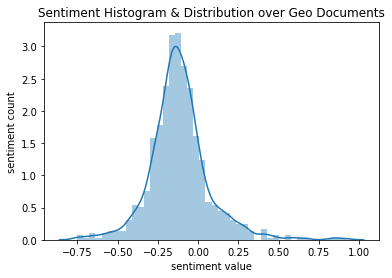

In [33]:
sns.distplot(train_dataset['SENTIMENT'], norm_hist=True)
plt.xlabel('sentiment value')
plt.ylabel('sentiment count')
plt.title('Sentiment Histogram & Distribution over Geo Documents')

In [34]:
train_dataset['Y'].value_counts()

False    36575
True       436
Name: crime, dtype: int64

In [35]:
#train_dataset

In [36]:
#threat_datasets

#### LDA

In [37]:
print_top_words_LDA(train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 15)

Topic #0: url | IL | , | Chicago | I'm | ) | (@ | - | ( | B | w/ | . | Lot | … | ?
Topic #2: Day | url | : | Beach | ( | ) | Park | Howard | Jarvis | Answer | Question | Rogers | Unasked | His | 1
Topic #3: . | url | lady | young | … | easy | eas | Matter | hard | times | fact | didn’t | Well | DAY | CLOSING
Topic #5: S | Reopened | earlier | pearl_boutique_store | announce | absolutely | 10 | years | devestated | 123rd | Wolf | 104th | accident | W | We
Topic #6: Grace | The | Made | … | N | 11411 | S | 773-468-0473 | Michigan | Style | Ave | ’ | Today | Is | Be
Topic #7: url | … | . | ! | Chatham | • | , | This | & | amazing | Countryside | thing | vacation | We're | IL
Topic #11: Ridge | Fitness | Country | Club | . | Mall | XSport | Here | I | Gleneagles | Sherrie | ! | AMC | 6 | Striving
Topic #12: url | , | … | Chicago | Englewood | !! | . | - | I | ! | Customs | LMG | thesummersmash | This | ”
Topic #13: url | … | Seatgeek | Stadium | , | . | ! | ) | .. | ( | 🇺🇸 | Chicago | Brid

Topic #107: url | … | , | . | Retail | Saturday | Associate | The | .. | Bar | Tools | Harbor | Freight | Play | &
Topic #108: Trader | url | Joe's | JosephsBrau | Um | ( | ) | . | Watching | Missing | Style | weeks | Last | church | Black
Topic #109: JS | Angular | Mr. | Mtf | Mt | Ms. | Ms | Mrs. | Mrs | Mr | Much | Mozzarella | Moxy | Moxie | Moving
Topic #110: url | … | ! | . | time | , | 😩😩 | : | “ | today | Happy | ” | lugar | amazing | day
Topic #111: St | police | activity | NB/SB | Both | Closed | 105th | 103rd | Mason | N | Movie | Movin | Moving | Moxie | Moxy
Topic #112: url | … | , | . | Chicago | ! | I | IL | .. | The | - | : | ) | & | I'm
Topic #113: url | , | … | IL | " | . | job | Company | Little | & | : | Hospital | Mary | like | Health
Topic #114: url | . | … | The | I | , | Park | – | Hyde | Kenwood | Historic | ! | District | : | Edition
Topic #117: 1h | 29m | 17s | 20.23 | Mr. | Mtf | Mt | Ms. | Ms | Mrs. | Mrs | Mozzarella | Mr | Much | Moxy
Topic #118: ! | Ho |

Topic #218: url | Soldier | … | Field | . | , | ! | en | The | Stones | Rolling | la | Chicago | !! | ..
Topic #220: eisenhower | Tri-State | accident | Off-ramp | closed | Eisenhower | Expy | inbound | NB | Moving | Moxie | Moxy | Ms. | Movin | Mozzarella
Topic #222: : | 1223S | 1225S | Always | 122S | There | Afrique | Black | Freeman | It | Dance | Russ | Lay | Silver | Lining
Topic #223: Side | url | Far | , | ❤ | … | .. | Community | Chicago | . | Illinois | Center | Southeast | Pullman | 💜
Topic #224: url | … | Park | Ridge | Illinois | 🇺🇸 | Anthony | game | We | friendly | 4th | , | wish | Markanich | USL
Topic #225: 127th | McDonald's | & | Ashland | Riverdale | homee | don’t | I’m | Calumet | I-57 | Exit | blocked | Real | men | Inbound
Topic #226: tour | listing | virtual | url | See | looking | Unit | Camden | 10201 | J | Lane | buyer | I | Most | Moxie
Topic #228: Lincoln | url | Park | Zoo | . | ! | … | The | Just | : | photo | , | posted | I | holiday
Topic #229: url | . 

In [94]:
d= train_dataset['LDA']['docs']

In [95]:
d= dict(d)

In [96]:
#for key,val in d.items():
#    print(key, "=>", val)

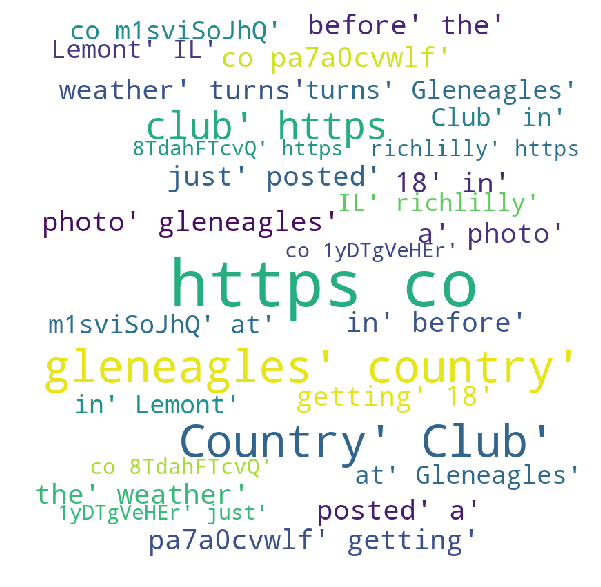

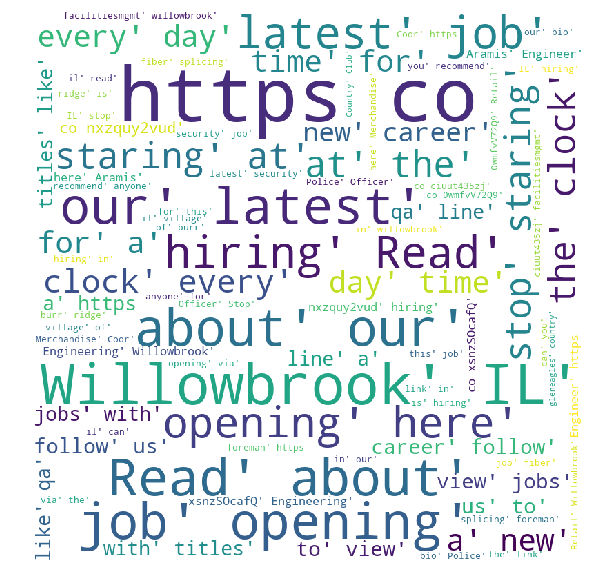

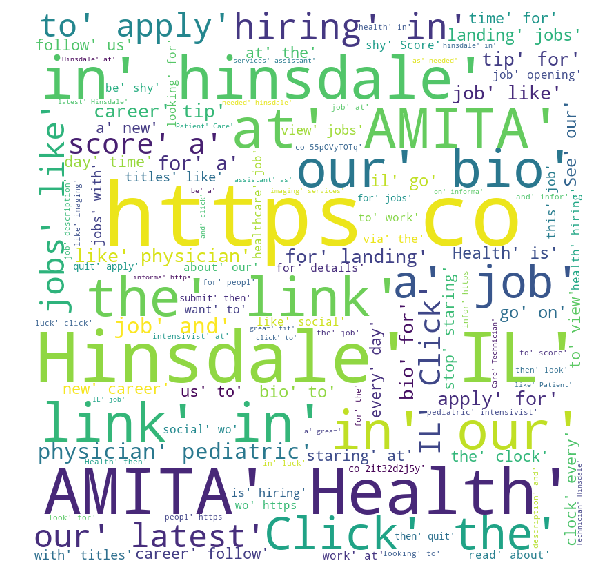

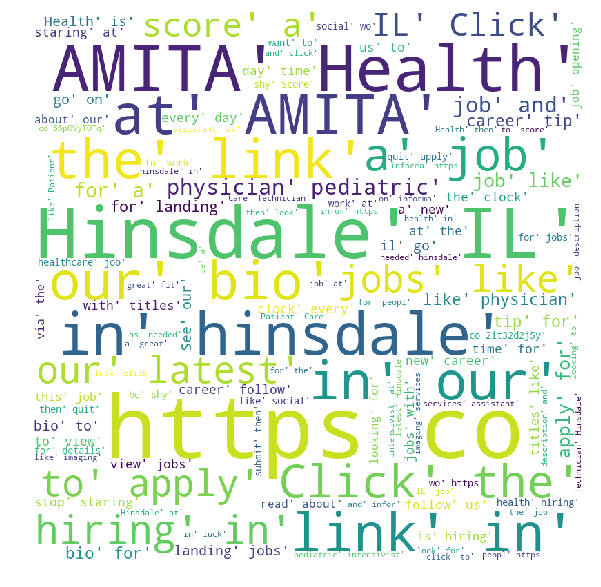

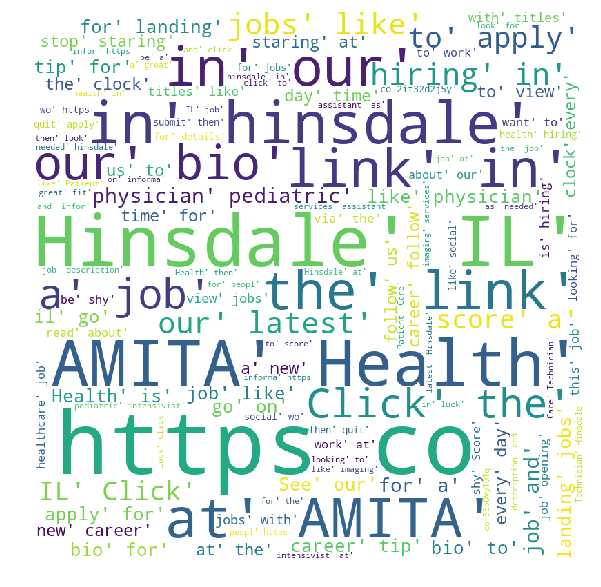

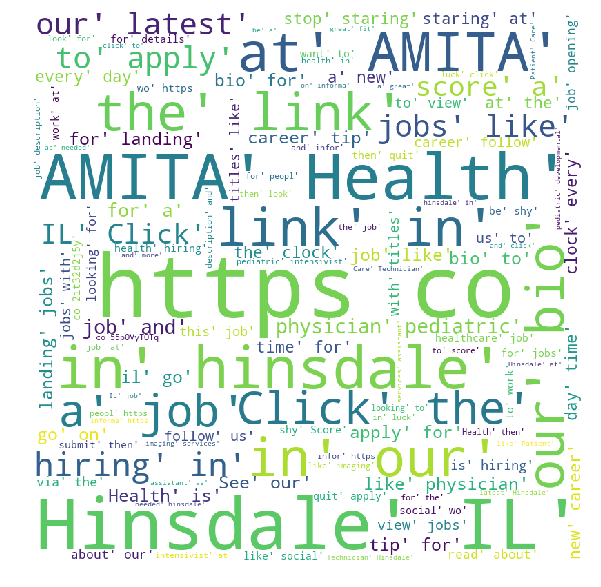

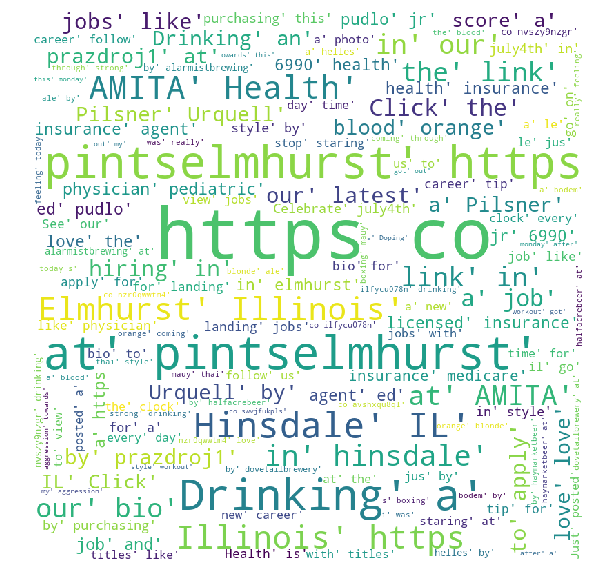

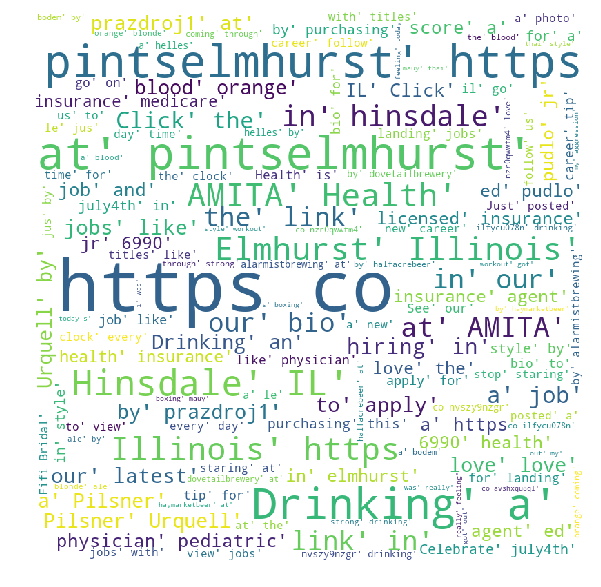

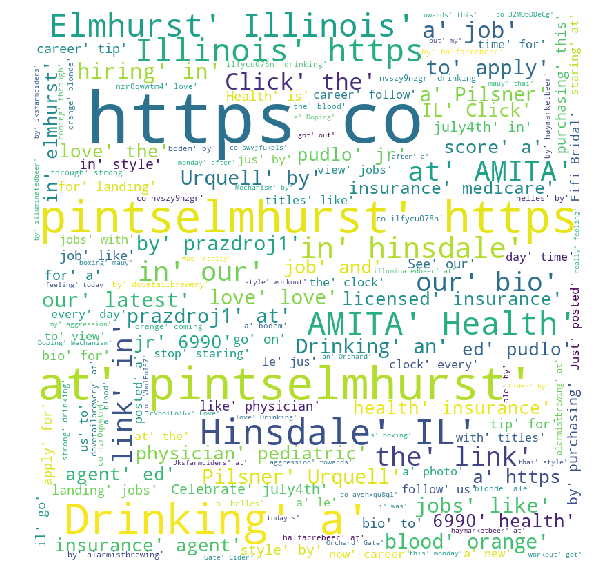

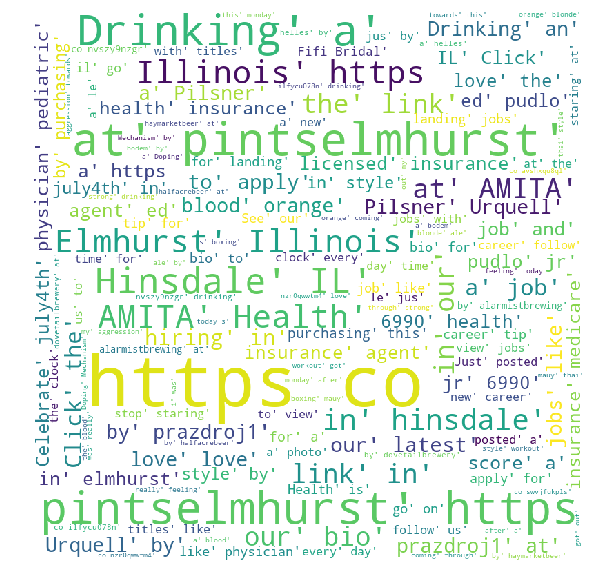

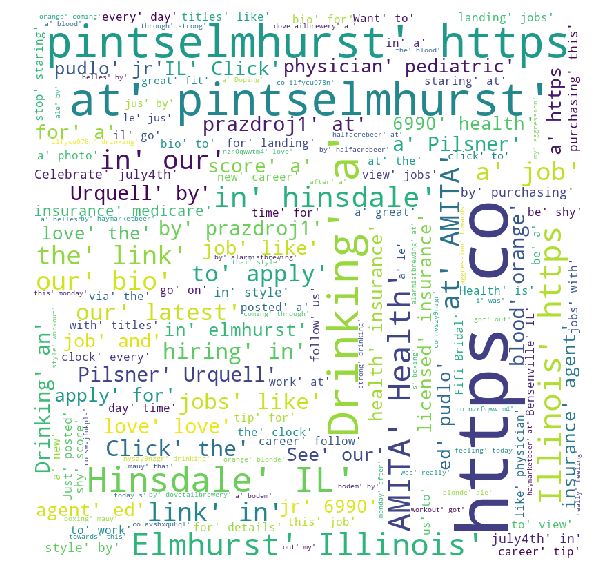

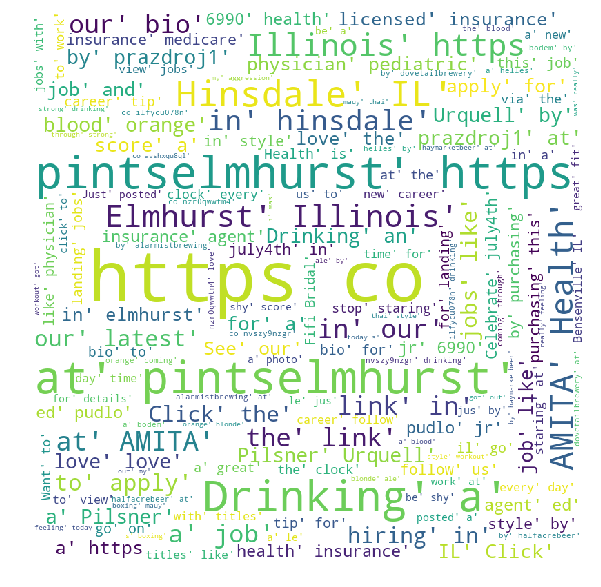

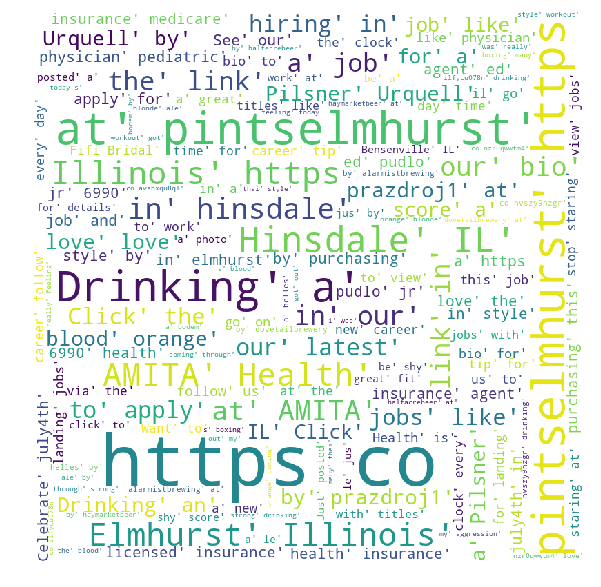

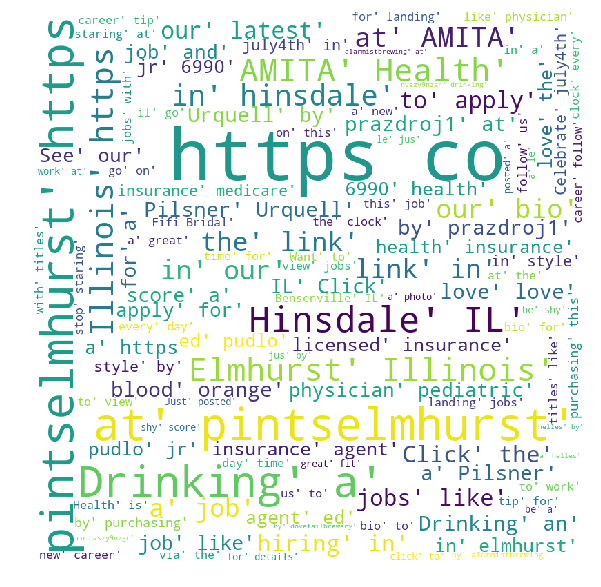

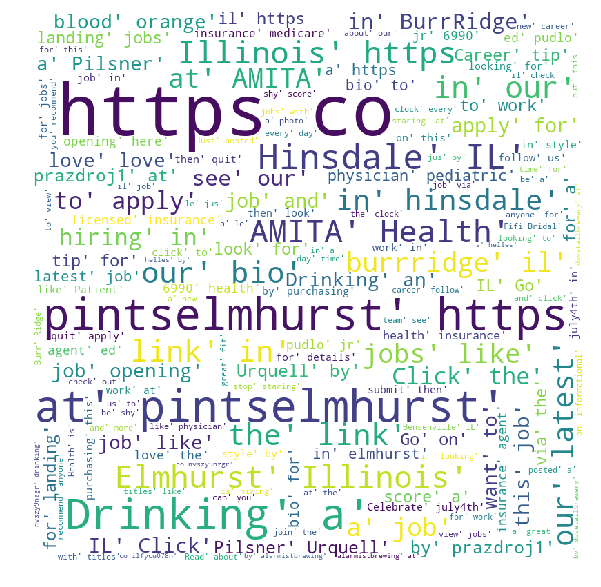

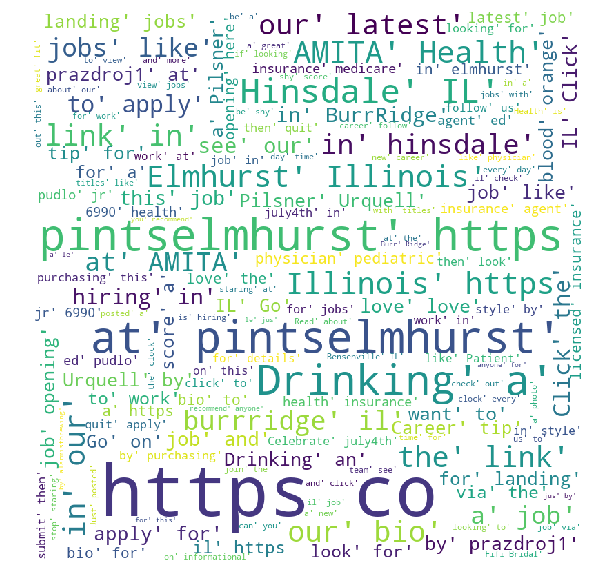

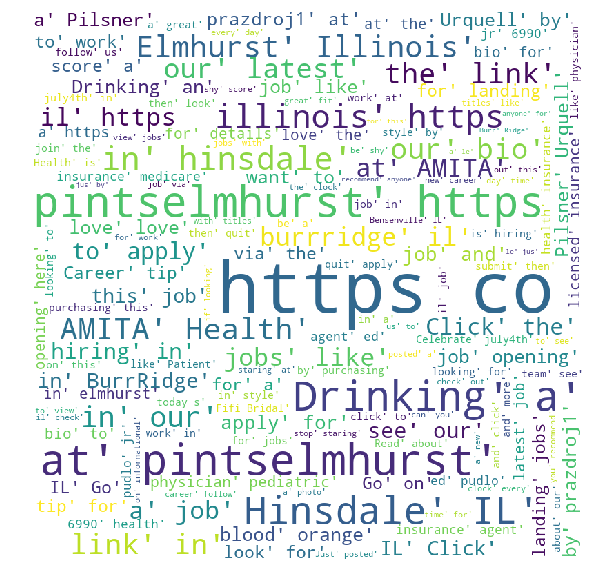

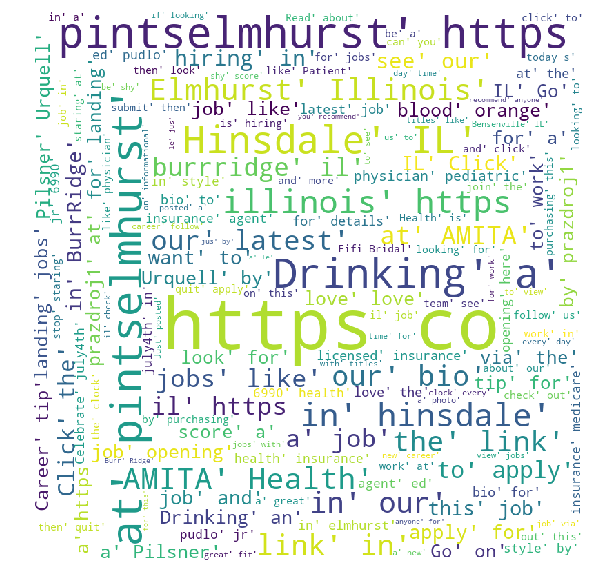

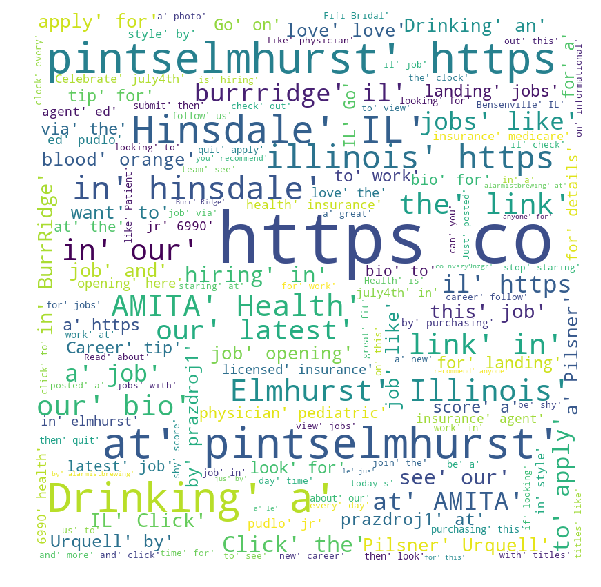

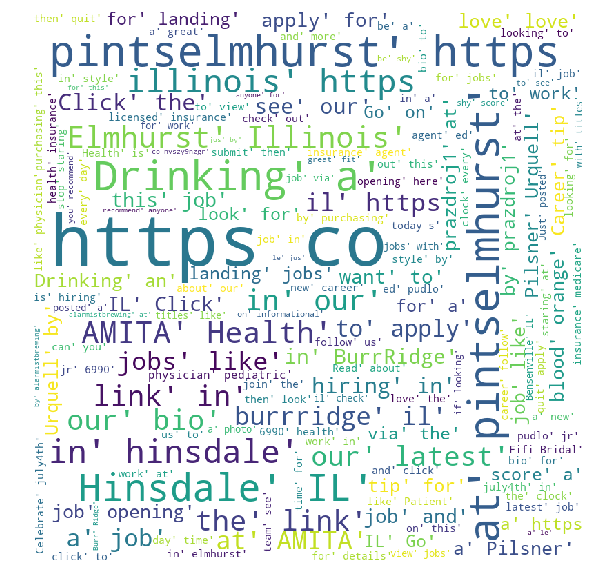

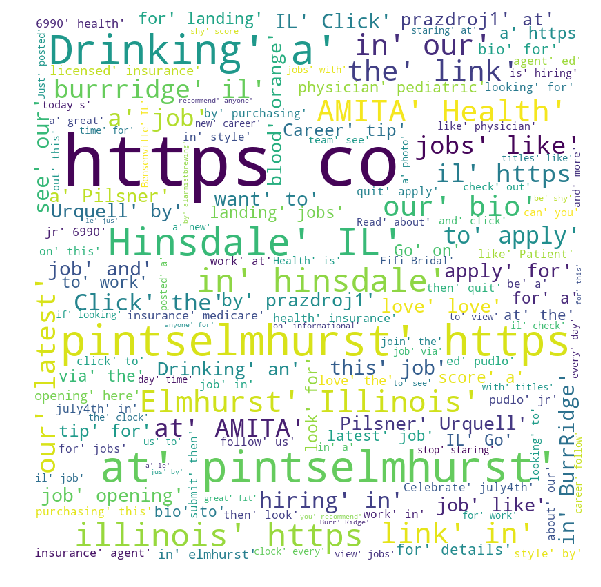

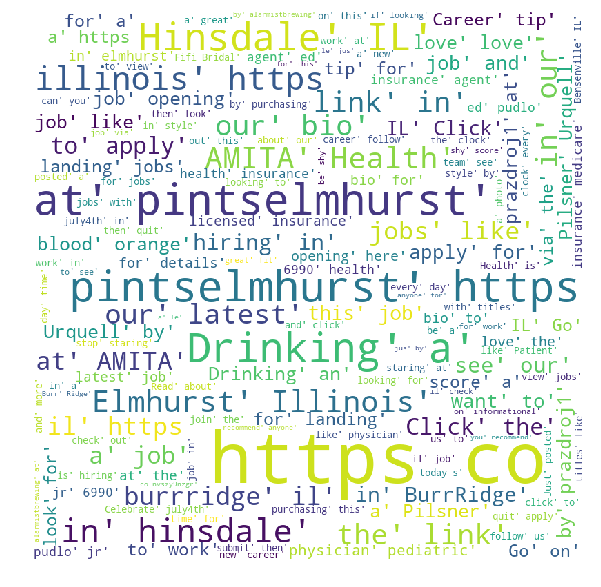

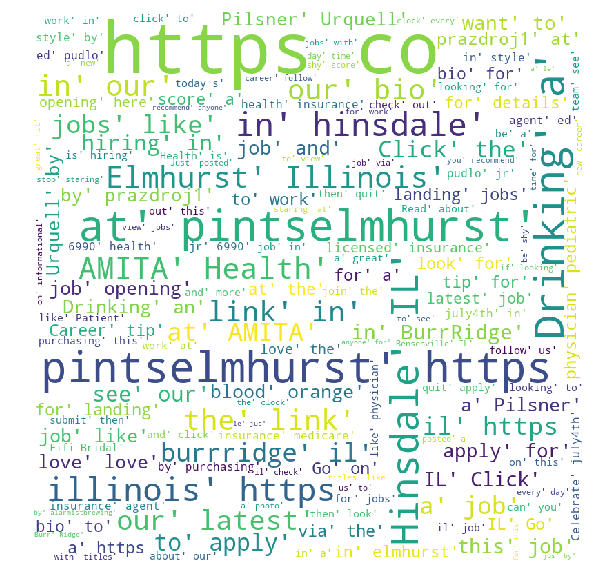

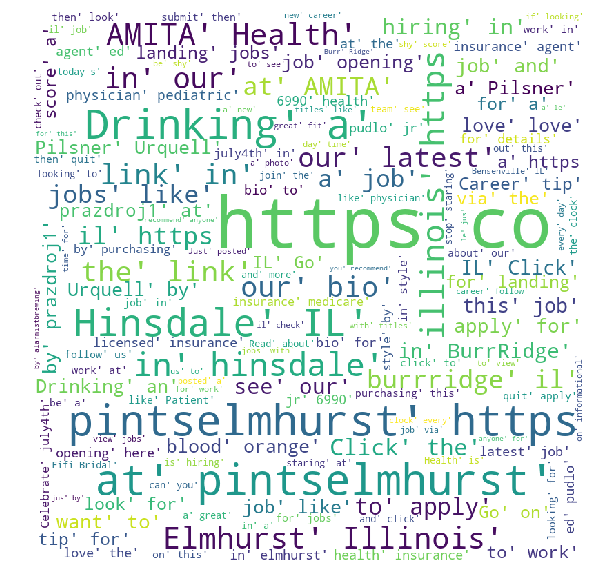

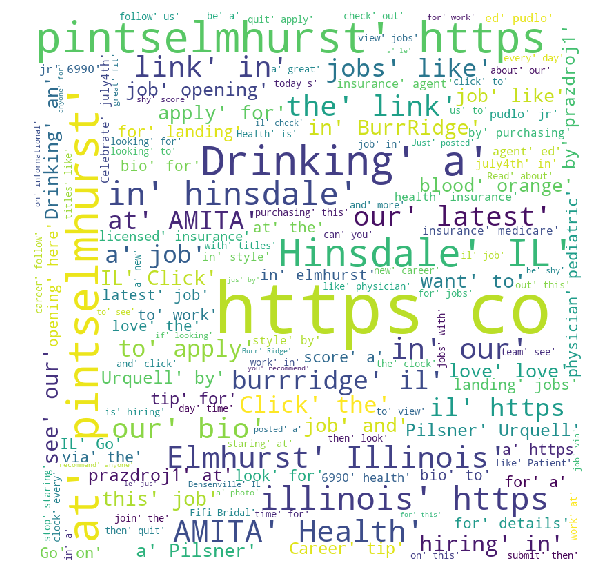

KeyboardInterrupt: 

In [119]:
# iterate through the csv file 
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd


comment_words = ' '
stopwords = set(STOPWORDS) 
  

for val in d.items():  
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
         tokens[i] = tokens[i].lower() 
          
         for words in tokens: 
                 comment_words = comment_words + words + ' '
  
  
    wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white', 
                        stopwords = stopwords, 
                        min_font_size = 10).generate(comment_words) 
    
# plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

Lets try to examine one "interesting" topic vector. First we check which ones have the maximal variance in its values.

In [41]:
lda_model=(train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 15)

In [42]:
print(np.argsort(train_dataset['LDA']['model'].components_.std(axis=1))[::-1][:5])

[275 305 304 196 345]


Lets pick up the maximal one in this sense.

In [43]:
exmple_topic_id = np.argsort(train_dataset['LDA']['model'].components_.std(axis=1))[-1]
print(exmple_topic_id)
example_topic_column_name = 'T{:03}'.format(exmple_topic_id)

275


In [44]:
get_topic_top_words_LDA(exmple_topic_id, train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 15)

['url',
 ',',
 '.',
 '…',
 'Chicago',
 '!',
 'Illinois',
 'I',
 'The',
 '—',
 '..',
 ':',
 '-',
 '!!',
 '•']

## Crime Prediction

In [45]:
surveillance_data, threat_datasets = generate_surveillance_data(train_dataset,
                                                                evaluation_dataset)

### Logic Regression Coefficients
*Note: All features were standatarized, therefore there is a meaning for coefficeints comparing.*

#### SENTIMENT model

Most dominant coefs indices: [0 1]


0

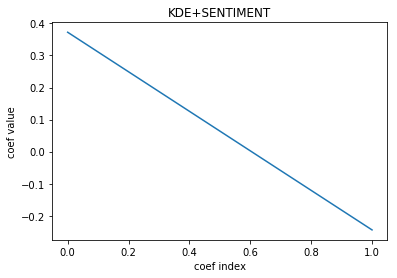

In [46]:
plot_log_reg_coef(threat_datasets, 'KDE+SENTIMENT')

#### KDE+LDA model

Most dominant coefs indices: [337 165  42 318  86]


337

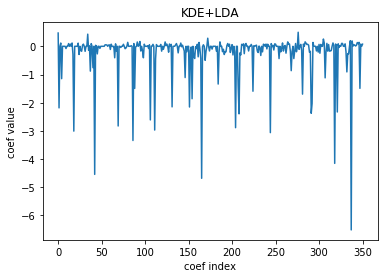

In [47]:
plot_log_reg_coef(threat_datasets, 'KDE+LDA')

In [48]:
train_dataset['Y'].value_counts()

False    36575
True       436
Name: crime, dtype: int64

#### KDE+SENTIMENT+LDA model

Most dominant coefs indices: [338 166  43 319  87]


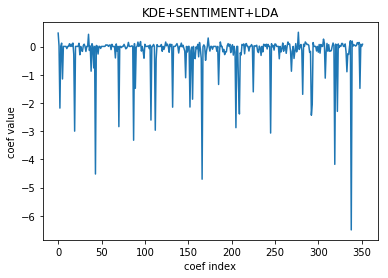

In [49]:
most_dominant_coefs_index = plot_log_reg_coef(threat_datasets, 'KDE+SENTIMENT+LDA') - 2

Examining the top words for the most dominant logistic regression coefficent topic:

In [50]:
get_topic_top_words_LDA(most_dominant_coefs_index,
                        train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 35)


['url',
 '…',
 '.',
 ',',
 'Way',
 '“',
 '”',
 'The',
 'Leadership',
 'Indiana',
 'Lead',
 'wonderful',
 '..',
 'Program',
 'closing',
 'Northwest’s…',
 'University',
 'Certification',
 'miedo',
 'What',
 '!',
 'el',
 '✨',
 'Point',
 '?',
 '101',
 'summer',
 'success',
 'it’s',
 'y',
 'Our',
 'e',
 'Summer',
 'When',
 'time']

### Surveillance Plot & AUC

In [51]:
normalized_surveillance_data = surveillance_data.cumsum(axis=1) / surveillance_data.sum(axis=1)[:, None]

63.88235294117647 KDE
62.76470588235294 KDE+SENTIMENT
70.67647058823529 KDE+LDA
70.70588235294117 KDE+SENTIMENT+LDA
100.05882352941177 ACTUAL


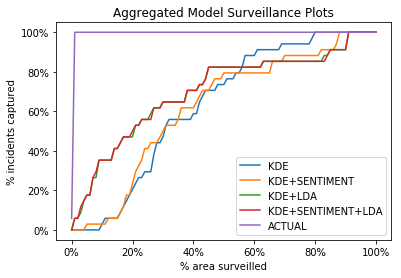

In [52]:
plot_surveillance_data(normalized_surveillance_data, threat_datasets.keys())


63.88235294117647 KDE
62.76470588235294 KDE+SENTIMENT
70.67647058823529 KDE+LDA
70.70588235294117 KDE+SENTIMENT+LDA
100.05882352941177 ACTUAL
None


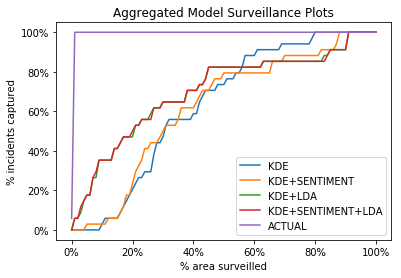

In [53]:
plt.figure()

print(plot_surveillance_data(normalized_surveillance_data, threat_datasets.keys()))





In [54]:
a= calc_AUCs(normalized_surveillance_data, threat_datasets)

In [55]:
a

KDE KDE+SENTIMENT   KDE+LDA KDE+SENTIMENT+LDA
KDE+SENTIMENT      -0.011362                                          
KDE+LDA             0.068677      0.080039                            
KDE+SENTIMENT+LDA   0.068723      0.080084  0.000046                  
ACTUAL              0.365176      0.376537  0.296499          0.296453

In [56]:
import gensim
import gensim.corpora as corpora
from pprint import pprint

In [57]:
dataset= train_dataset['LDA']['docs'].iloc[2]

values = ','.join(str(v) for v in dataset)

In [58]:


id2word = corpora.Dictionary(dataset)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in dataset]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())



[(0,
  '0.072*"fit" + 0.072*"great" + 0.072*"This" + 0.057*"Security" + 0.057*"it" '
  '+ 0.057*"see" + 0.057*"might" + 0.057*"Guard" + 0.057*"#security" + '
  '0.018*"could"'),
 (1,
  '0.063*"," + 0.049*"on" + 0.042*"We\'re" + 0.041*""" + 0.040*"#Hinsdale" + '
  '0.039*"in" + 0.039*"IL" + 0.034*"Want" + 0.034*"details" + 0.031*"for"'),
 (2,
  '0.045*"See" + 0.025*"openings" + 0.025*"https://t.co/JY7F8u62Yi" + '
  '0.025*"including" + 0.025*"Spi" + 0.025*"#HealthWelfare" + '
  '0.025*"teammates" + 0.025*"Director" + 0.025*"Banker" + 0.025*")"'),
 (3,
  '0.092*"IL" + 0.092*"," + 0.086*"#Hinsdale" + 0.085*"in" + 0.055*":" + '
  '0.051*"our" + 0.032*"bio" + 0.032*"link" + 0.030*"this" + 0.026*"job"'),
 (4,
  '0.005*"latest" + 0.005*"be" + 0.005*"We\'re" + 0.005*"is" + 0.005*"See" + '
  '0.005*"this" + 0.005*"https://t.co/Li64eEzryg" + 0.005*"more" + 0.005*"-" + '
  '0.005*"Developmental"'),
 (5,
  '0.075*"a" + 0.061*""" + 0.058*"be" + 0.045*"Hinsdale" + 0.039*"-" + '
  '0.038*"job" + 0.03

In [59]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.188316  0.096486       1        1  33.436375
3      0.138262 -0.223814       2        1  16.983505
1      0.060615 -0.066445       3        1  14.616733
5     -0.004025  0.159539       4        1  14.257501
8      0.031951  0.125199       5        1  13.761239
2     -0.110357 -0.030596       6        1   3.339842
0     -0.206909 -0.045033       7        1   2.768077
7     -0.048927 -0.007668       8        1   0.418366
4     -0.048927 -0.007668       9        1   0.418366, topic_info=     Category       Freq                     Term      Total  loglift  logprob
term                                                                          
4     Default  13.000000                       IL  13.000000  30.0000  30.0000
1     Default  12.000000                #Hinsdale  12.000000  29.0000  29.0000
38    Default  11.000000                        a  11.000000  28.0000  28.0000
2     Default  21.000000                        ,  21.000000  27.0000  27.0000
24    Default  11.000000                        -  11.000000  26.0000  26.0000
11    Default  19.000000                       in  19.000000  25.0000  25.0000
112   Default   6.000000                    apply   6.000000  24.0000  24.0000
47    Default  13.000000                    AMITA  13.000000  23.0000  23.0000
49    Default  13.000000                   Health  13.000000  22.0000  22.0000
23    Default  15.000000                        "  15.000000  21.0000  21.0000
39    Default   5.000000                       be   5.000000  20.0000  20.0000
56    Default  12.000000                       to  12.000000  19.0000  19.0000
3     Default   6.000000                        :   6.000000  18.0000  18.0000
15    Default  11.000000                      our  11.000000  17.0000  17.0000
48    Default   9.000000                    Click   9.000000  16.0000  16.0000
52    Default  12.000000                       at  12.000000  15.0000  15.0000
103   Default   4.000000                       on   4.000000  14.0000  14.0000
87    Default   7.000000                      and   7.000000  13.0000  13.0000
17    Default  11.000000                      the  11.000000  12.0000  12.0000
30    Default   5.000000                 Hinsdale   5.000000  11.0000  11.0000
51    Default   4.000000                    We're   4.000000  10.0000  10.0000
13    Default   9.000000                     link   9.000000   9.0000   9.0000
7     Default   9.000000                      bio   9.000000   8.0000   8.0000
9     Default  16.000000                      for  16.000000   7.0000   7.0000
54    Default   6.000000                   hiring   6.000000   6.0000   6.0000
44    Default   6.000000                        !   6.000000   5.0000   5.0000
12    Default  14.000000                      job  14.000000   4.0000   4.0000
77    Default   3.000000                Pediatric   3.000000   3.0000   3.0000
78    Default   3.000000                Physician   3.000000   2.0000   2.0000
50    Default   3.000000                     Want   3.000000   1.0000   1.0000
...       ...        ...                      ...        ...      ...      ...
39     Topic9   0.013714                       be   5.627523  -0.5404  -5.2311
131    Topic9   0.013714                   latest   2.911380   0.1186  -5.2311
186    Topic9   0.013714                referrals   2.625580   0.2220  -5.2311
58     Topic9   0.013714                     It's   3.862908  -0.1642  -5.2311
66     Topic9   0.013714  https://t.co/2IT32D2J5Y   1.666551   0.6765  -5.2311
65     Topic9   0.013714                    every   1.666551   0.6765  -5.2311
64     Topic9   0.013714                      day   1.666551   0.6765  -5.2311
63     Topic9   0.013714                    clock   1.666551   0.6765  -5.2311
62     Topic9   0.013714                   career   1.666551   0.6765  -5.2311
61     Topic9   0.013714                     

In [50]:
from utils.geo import N_CHICAGO_THREAT_GRID_LIST

ab =  np.zeros((5, N_CHICAGO_THREAT_GRID_LIST))

In [44]:
#reading the pickle 200

N_CHICAGO_THREAT_GRID_LIST



36575

In [ ]:
def calc_AUCs_new(agg_surveillance_data, model_names):
    """
    Calculate the Area Under the Curve (AUC) for all the pairs for models.
    """

    model_names_list = list(model_names)
    aucs = pd.DataFrame(columns=model_names_list[:-1], index=model_names_list[1:], dtype=float)

    step_for_precentage = int(len(agg_surveillance_data[0]) / 100)
    agg_surveillance_precentages = agg_surveillance_data[:,
                                                         ::step_for_precentage]

    for model_index, model_name in enumerate(model_names):
        plt.plot(agg_surveillance_precentages[model_index], label=model_name)
        print(agg_surveillance_precentages[model_index].sum(),model_name)
    precentage_ticks = ['{}%'.format(p) for p in range(0, 101, 20)]

    plt.xticks(range(0, 101, 20), precentage_ticks)
    plt.yticks(np.arange(0, 1.1, 0.2), precentage_ticks)
    plt.title('Aggragetd Model Surveillance Plots')
    plt.xlabel('% area surveilled')
    plt.ylabel('% incidents captured')
    plt.legend(loc="lower right")
               
        
        
   

In [ ]:
calc_AUCs_new(normalized_surveillance_data, threat_datasets)

In [ ]:

def plot_surveillance_data(agg_surveillance_data, model_names):
    step_for_precentage = int(len(agg_surveillance_data[0]) / 100)
    agg_surveillance_precentages = agg_surveillance_data[:,
                                                         ::step_for_precentage]

    for model_index, model_name in enumerate(model_names):
        plt.plot(agg_surveillance_precentages[model_index], label=model_name)
        
        

In [ ]:
from utils.surveillance import calc_AUCs_new

## Full Training & Evaluation over all the period (~60 steps of 31 days)
**TAKES ~3 HOURS, CHANGE THE VARIABLE `is_full_run` TO `True` IN ORDER TO PREFORM IT**

In [43]:
is_full_run = True

In [44]:
if is_full_run:
    agg_surveillance_data, all_threat_datasets = generate_all_data_surveillance_data(crimes_data, tweets_data, 31)   

100%|██████████| 42/42 [3:41:42<00:00, 160.07s/it]  


56.8164610444482 KDE
66.96569207368599 KDE+SENTIMENT
84.40949805644753 KDE+LDA
84.38837248605712 KDE+SENTIMENT+LDA
100.02213959776914 ORACLE


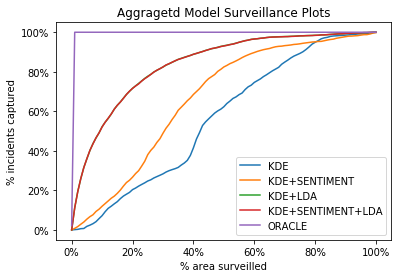

In [45]:
if is_full_run:
    plot_surveillance_data(agg_surveillance_data, all_threat_datasets[0][1].keys())

In [46]:
if is_full_run:
    print('AUC betwwen models')
    print(calc_AUCs(agg_surveillance_data, all_threat_datasets[0][1].keys()))

AUC betwwen models
                        KDE KDE+SENTIMENT    KDE+LDA KDE+SENTIMENT+LDA
KDE+SENTIMENT      0.101319                                           
KDE+LDA            0.275510      0.174191                             
KDE+SENTIMENT+LDA  0.275283      0.173963  -0.000227                  
ORACLE             0.434334      0.333015   0.158824          0.159051
